# Simulating Caching efficiencies
<B>For a given time period and site calculates what would have been a cache performance depending on the cache size.</B>

In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

lastHours = 48
site      = 'BNL-ATLAS'
#site='WT2'
cacheSize = 10*1024 # in GB
highWater = 95 # in percents
lowWater  = 90

In [2]:
es = Elasticsearch(hosts=[{'host':'uct2-es-door.mwt2.org', 'port':9200}],timeout=60)

In [3]:
hW = cacheSize*1024*1024*10.24 * highWater
lW = cacheSize*1024*1024*10.24 * lowWater
currentTime=int(round(datetime.utcnow().timestamp()* 1000))
startTime=currentTime - lastHours*3600000 
searchString={
    "fields": ["timestamp", "filename", "filesize", "read", "readv"],
    "query":{
        "filtered":{
            "query":{
                "term": {"site": { "value": site } }
            },
            "filter":{
                "range":{"timestamp":{"gte": startTime,"format": "epoch_millis"}}
            }
        }
    },
    "sort": { "timestamp": { "order": "asc" }}
}

Actually running the search

In [4]:
scroll = scan(es, query=searchString, index='detailed_stream', scroll='10s')
RawData=[]
for res in scroll:
    r = res['fields']
    fn = r['filename'][0]
    if 'ivukotic' in fn: continue # skipping test files.
    ts = r['timestamp'][0]
    fs = r['filesize'][0]
    rs = r['read'][0]+r['readv'][0]
    RawData.append([fn,ts,fs,rs])
print ("results fetched:", len(RawData) ) 
RawData.sort(key=lambda tup: tup[1])

results fetched: 59625


In [5]:
#plotting lists
dates=[]; cachesizeInT=[]
datesC=[]; cached=[]
datesD=[]; direct=[]

#running variables
totalDataDelivered=0
totalFilesize=0
currentCacheSize=0
cachedFiles={}
cacheHits=0
deliveredFromCache=0
cleaningOrder=[]
for r in RawData:
    fn = r[0]
    ts = r[1]
    fs = r[2]
    rs = r[3]
    totalDataDelivered += rs
    totalFilesize += fs
    if fn in cachedFiles:
        cacheHits += 1
        deliveredFromCache += rs
        datesC.append(datetime.fromtimestamp(ts/1000))
        cached.append(rs)
#         print(fn)
        for ind in range(len(cleaningOrder)):
            if cleaningOrder[ind][0]==fn: break
        cleaningOrder.pop(ind)
        cleaningOrder.append([fn,rs])
    else:
        if fs+currentCacheSize>hW: #crossing high water mark
            cleanedUpFiles=0
            cleanedUpSize=0
            while currentCacheSize>lW:
                [toRemove_fn,toRemove_rs]=cleaningOrder.pop(0)
                cleanedUpFiles+=1
                cleanedUpSize+=toRemove_rs
                currentCacheSize -= toRemove_rs
                try:
                    del cachedFiles[toRemove_fn]
                except:
                    print(toRemove_fn, toRemove_rs)
#             print(datetime.fromtimestamp(ts/1000),"cleaned up",cleanedUpFiles,"files or",cleanedUpSize/1024/1024/1024,'GB')
            
        cachedFiles[fn]=[fs,ts]
        cleaningOrder.append([fn,rs])
        currentCacheSize += rs
        datesD.append(datetime.fromtimestamp(ts/1000))
        direct.append(rs)
        
    dates.append(datetime.fromtimestamp(ts/1000))
    cachesizeInT.append(currentCacheSize)
    
print ("Data delivered: ", totalDataDelivered/1024/1024/1024/1024, "TB")
print ("Filesize: ", totalFilesize/1024/1024/1024/1024, "TB")
print ("Cache hits: ", cacheHits)
print ("Delivered from cache: ", deliveredFromCache/1024/1024/1024/1024, "TB")

Data delivered:  40.82725246195332 TB
Filesize:  113.98358101158647 TB
Cache hits:  16778
Delivered from cache:  6.301459991649608 TB


<B>cache fill plot</B>

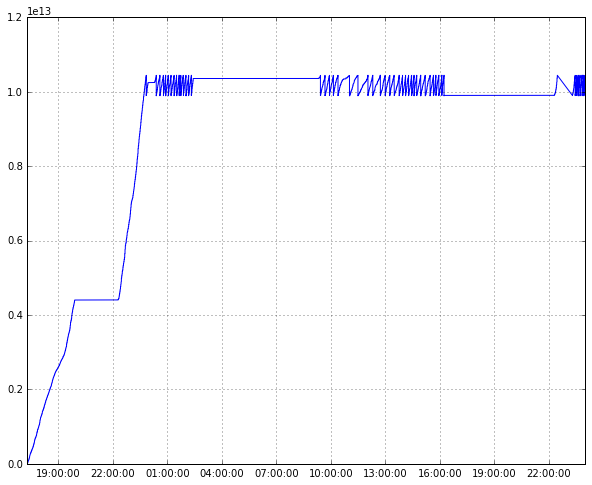

In [6]:
fig, ax = plt.subplots()
cacheFilePlot = ax.plot_date(dates, cachesizeInT, '-')

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)

ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)

fig = plt.gcf()
fig.set_size_inches(10, 8)

ax.grid(True)

<B>delivered from cache vs directly</B>


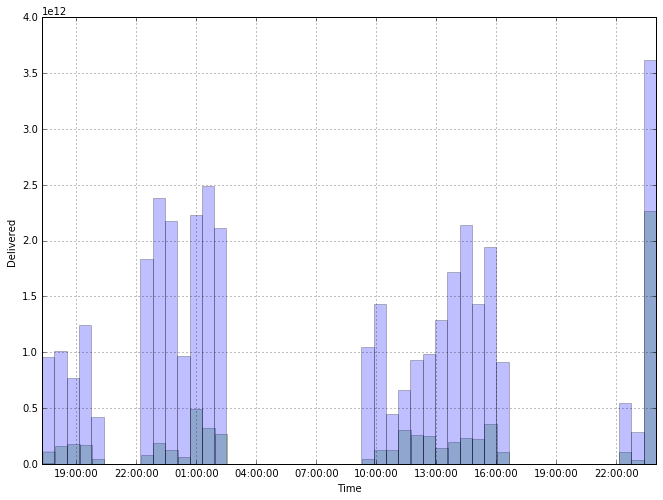

In [7]:
n, bins, patches = plt.hist(datesC, 50, weights=cached, facecolor='green', alpha=0.25)
n, bins, patches = plt.hist(datesD, 50, weights=direct, facecolor='blue', alpha=0.25)

plt.xlabel('Time')
plt.ylabel('Delivered')
# plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
plt.grid(True)

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)
ax = plt.gca()
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)

fig = plt.gcf()
fig.set_size_inches(11, 8)

plt.show()




